In [8]:
import os
import csv

# Define your folder paths
root_dir = "./"
label_map = {
    "Harrasments": 1,
    "Accident": 1,
    "traffic": 0
}

# Output CSV
csv_filename = "image_labels.csv"

# Create the CSV file
with open(csv_filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["filename", "label"])
    
    for folder, label in label_map.items():
        folder_path = os.path.join(root_dir, folder)
        for img_file in os.listdir(folder_path):
            if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(folder, img_file)
                writer.writerow([img_path, label])

print(f"CSV saved to {csv_filename}")


CSV saved to image_labels.csv


In [9]:
import pandas as pd
df=pd.read_csv("image_labels.csv")

In [11]:
df["label"].value_counts()

label
1    623
0    614
Name: count, dtype: int64

In [12]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader


In [14]:
# Configuration
CSV_PATH = "image_labels.csv"       # your label CSV
ROOT_DIR = "./"            # root folder containing subfolders
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
BATCH_SIZE = 16
EPOCHS = 20
LR = 0.0005
WEIGHT_DECAY = 1e-4


cuda


In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [16]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.data.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label


In [17]:
dataset = ImageDataset(CSV_PATH, ROOT_DIR, transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
model = models.vgg16(pretrained=True)

# Freeze convolutional layers
for param in model.features.parameters():
    param.requires_grad = False


C:\Users\lakshman parsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\lakshman parsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\lakshman parsi/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|███████████████████████████████████████████████████████████████████████████████| 528M/528M [02:58<00:00, 3.10MB/s]


In [18]:
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(4096, 2048),
    nn.ReLU(),
    nn.Dropout(0.4),

    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),

    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(128, 2)  # Final output layer for 2 classes
)

model = model.to(DEVICE)


In [20]:
criterion = nn.CrossEntropyLoss()
import matplotlib.pyplot as plt

# Only optimizing the classifier part (not the frozen conv layers)
optimizer = optim.Adam(model.classifier.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)


In [21]:
train_losses = []
train_accuracies = []


In [22]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


Epoch [1/10] Loss: 0.2129, Accuracy: 89.89%
Epoch [2/10] Loss: 0.0078, Accuracy: 99.68%
Epoch [3/10] Loss: 0.0001, Accuracy: 100.00%
Epoch [4/10] Loss: 0.0927, Accuracy: 98.87%
Epoch [5/10] Loss: 0.0436, Accuracy: 99.27%
Epoch [6/10] Loss: 0.1234, Accuracy: 99.11%
Epoch [7/10] Loss: 0.0000, Accuracy: 100.00%
Epoch [8/10] Loss: 0.0379, Accuracy: 99.27%
Epoch [9/10] Loss: 0.0005, Accuracy: 100.00%
Epoch [10/10] Loss: 0.0012, Accuracy: 99.92%


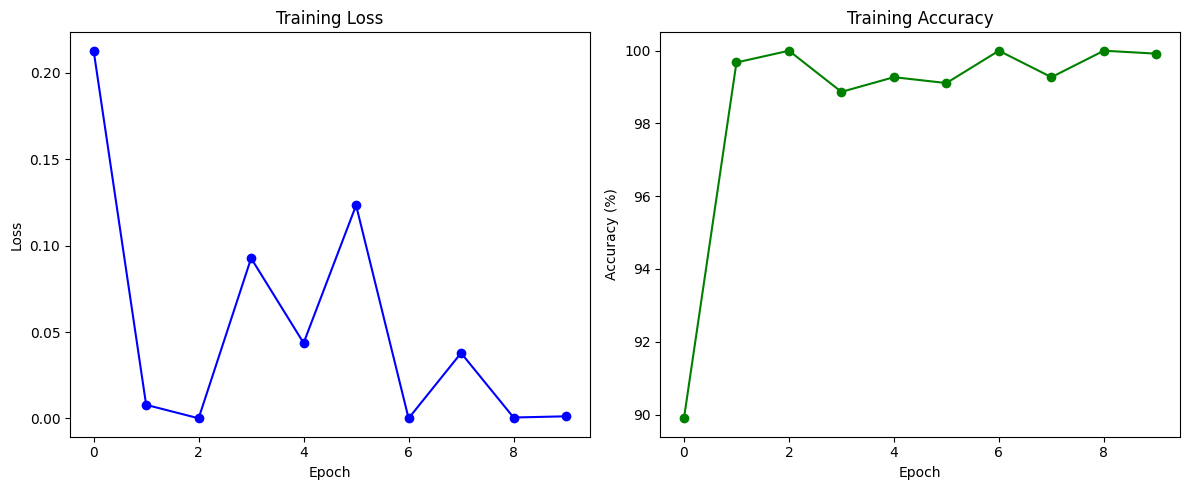

In [23]:
# Plotting
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', color='blue')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o', color='green')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()


In [24]:
MODEL_PATH = "vgg16_custom_binary.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


Model saved to vgg16_custom_binary.pth


In [31]:
from PIL import Image

# 🧠 Label map based on your training logic
label_map = {0: "Traffic", 1: "Harassment/Accident"}

# 🔍 Prediction function
def predict_test_image(model, image_path, transform):
    model.eval()

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(DEVICE)  # [1, 3, 224, 224]

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    pred_class = predicted.item()
    pred_label = label_map[pred_class]

    # Show image with predicted label
    plt.imshow(image)
    plt.title(f"Prediction: {pred_label} (Class {pred_class})")
    plt.axis("off")
    plt.show()

    return pred_class, pred_label


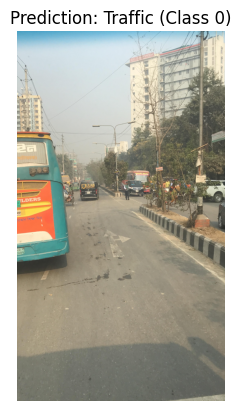

Class ID: 0
Predicted Label: Traffic


In [36]:
# 🖼️ Replace with your test image path
# test_image_path = ".\Accident\test23_26.jpg"
test_image_path = r"C:\Users\lakshman parsi\Desktop\datasets\traffic\140_jpg.rf.7c2a21221460b9d0dfd01660ab72c144.jpg"

# 🔮 Predict
class_id, class_label = predict_test_image(model, test_image_path, transform)

print(f"Class ID: {class_id}")
print(f"Predicted Label: {class_label}")


In [ ]:
# using saved model 
import torch
import torch.nn as nn
from torchvision import models

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_trained_model(model_path):
    model = models.vgg16(pretrained=False)  # pretrained=False because weights are loaded manually

    # Your custom classifier with 6 FC layers
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 2048),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(2048, 1024),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 2)
    )

    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model


: 

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

label_map = {0: "Traffic", 1: "Harassment/Accident"}

def predict_test_image(model, image_path, transform):
    model.eval()

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    class_id = predicted.item()
    class_label = label_map[class_id]

    plt.imshow(image)
    plt.title(f"Prediction: {class_label} (Class {class_id})")
    plt.axis("off")
    plt.show()

    return class_id, class_label


: 

C:\Users\lakshman parsi\AppData\Local\Temp\ipykernel_24264\484227738.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_lo

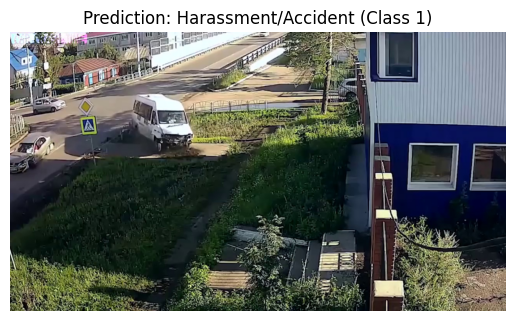

Predicted Class ID: 1
Predicted Label: Harassment/Accident


In [5]:
model_path = "vgg16_custom_binary.pth"
model = load_trained_model(model_path)

test_image_path = r"C:\Users\lakshman parsi\Desktop\datasets\Accident\test23_26.jpg"
# test_image_path = r"C:\Users\lakshman parsi\Desktop\datasets\traffic\140_jpg.rf.7c2a21221460b9d0dfd01660ab72c144.jpg"

class_id, class_label = predict_test_image(model, test_image_path, transform)

print(f"Predicted Class ID: {class_id}")
print(f"Predicted Label: {class_label}")
